In [0]:
import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [0]:
mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, 
                                         transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, 
                                        transform=transforms.ToTensor())

channels, width, height = mnist_train[0][0].size()

train_labeled = [(x, torch.Tensor([1])) for x, y in mnist_train]
test_labeled = [(x, torch.Tensor([1])) for x, y in mnist_test]

In [0]:
data = train_labeled + test_labeled

In [0]:
def sample_noise_minibatch(dim, batch_size):
    means = torch.zeros(dim * batch_size)
    samples = torch.normal(means, 1)
    labels = torch.zeros((batch_size, 1))
    return samples.view(batch_size, dim), labels

In [0]:
class DiscriminatorMLP(nn.Module):
    
    def __init__(self):
        super(DiscriminatorMLP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, 
                               kernel_size=6, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, 
                               kernel_size=5, stride=2)
        
        self.hidden1 = nn.Linear(160, 100, bias=False)
        self.dropout1 = nn.Dropout()
        self.hidden1_bn = nn.BatchNorm1d(100)
        
        self.hidden2 = nn.Linear(100, 50, bias=False)
        self.dropout2 = nn.Dropout()
        self.hidden2_bn = nn.BatchNorm1d(50)
        
        self.hidden3 = nn.Linear(50, 10, bias=False)
        self.hidden3_bn = nn.BatchNorm1d(10)
        
        self.output = nn.Linear(10, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        batch_size = x.size(0)
        x = x.view((batch_size, -1))
        x = self.dropout1(F.relu(self.hidden1(x)))
        x = self.dropout2(F.relu(self.hidden2(x)))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        return self.sigmoid(x)

In [0]:
class GeneratorMLP(nn.Module):
    
    def __init__(self, input_dim):
        super(GeneratorMLP, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(100, 280, 4, stride=2, padding=1),
            nn.BatchNorm2d(280),
            nn.ReLU(),
            nn.ConvTranspose2d(280, 180, 4, stride=2, padding=1), 
            nn.BatchNorm2d(180),
            nn.ReLU(),
            nn.ConvTranspose2d(180, 90, 6, stride=2, padding=1),
            nn.BatchNorm2d(90),
            nn.ReLU(),
            nn.ConvTranspose2d(90, 50, 6, stride=2, padding=1), 
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 20, 6, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.ConvTranspose2d(20, 1, 6, stride=1, padding=1))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(-1, 100, 1, 1)
        x = self.deconv(x)
        x = self.sigmoid(x)
        return x

In [0]:
def discriminator_criterion_neg(d_out, dofg_out):
    m = d_out.size(0)
    expr1 = torch.log(d_out)
    expr2 = torch.log(1 - dofg_out)
    summed = torch.sum((expr1 + expr2), 0)
    return - summed / m

In [0]:
def generator_criterion_early(dofg_out):
    m = dofg_out.size(0)
    logged = torch.log(dofg_out)
    summed = torch.sum(logged, 0)
    return - summed / m

In [0]:
def generator_criterion(dofg_out):
    m = dofg_out.size(0)
    logged = torch.log(1 - dofg_out)
    summed = torch.sum(logged, 0)
    return summed / m

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
n_iters = 60000
n_iters_altloss = 2500
batch_size = 64
noise_dim = 100
k = 1
lr_d = 0.0002
moment_d = 0.85
lr_g = 0.025
moment_g = 0.9
print_every = 500

data_sampler = torch.utils.data.RandomSampler(data, replacement=True, 
                                              num_samples=(batch_size * n_iters * k))
mnist_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=1, sampler=data_sampler)

Iter   500  |  D loss: 1.3872  G loss: -0.6922  D acc: 0.4219  G succ: 0.3125


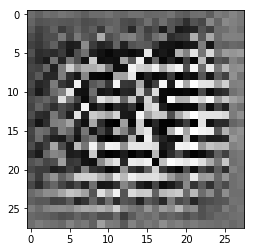

Iter  1000  |  D loss: 1.3857  G loss: -0.6931  D acc: 0.5469  G succ: 0.4688


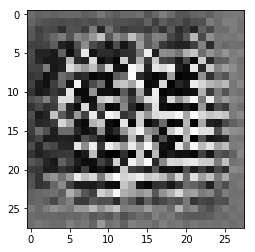

Iter  1500  |  D loss: 1.3862  G loss: -0.6937  D acc: 0.5078  G succ: 0.5781


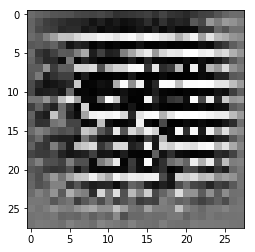

Iter  2000  |  D loss: 1.3866  G loss: -0.6936  D acc: 0.4219  G succ: 0.5312


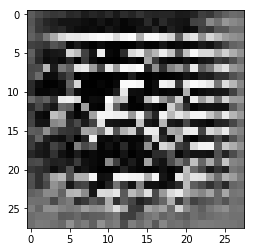

Iter  2500  |  D loss: 1.3864  G loss: -0.6938  D acc: 0.4766  G succ: 0.5781


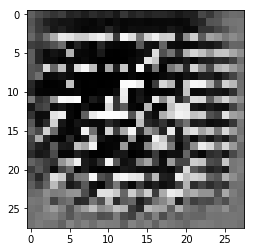

Iter  3000  |  D loss: 1.3865  G loss: -0.6931  D acc: 0.4609  G succ: 0.4375


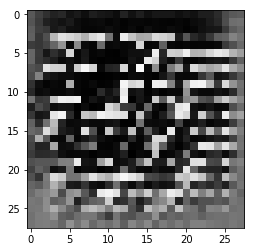

Iter  3500  |  D loss: 1.3860  G loss: -0.6934  D acc: 0.5312  G succ: 0.5312


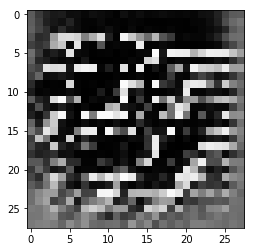

Iter  4000  |  D loss: 1.3861  G loss: -0.6929  D acc: 0.4844  G succ: 0.4375


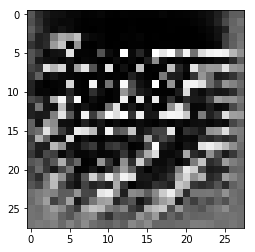

Iter  4500  |  D loss: 1.3866  G loss: -0.6928  D acc: 0.4453  G succ: 0.4219


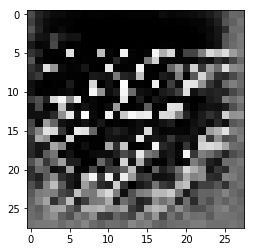

Iter  5000  |  D loss: 1.3862  G loss: -0.6931  D acc: 0.5156  G succ: 0.4375


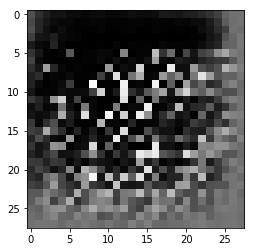

Iter  5500  |  D loss: 1.3858  G loss: -0.6931  D acc: 0.5312  G succ: 0.4688


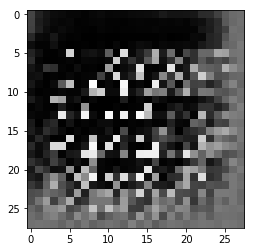

Iter  6000  |  D loss: 1.3867  G loss: -0.6931  D acc: 0.4375  G succ: 0.4844


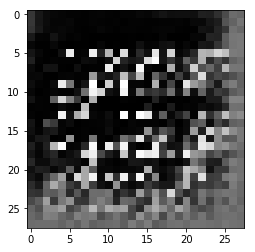

Iter  6500  |  D loss: 1.3861  G loss: -0.6928  D acc: 0.4609  G succ: 0.3906


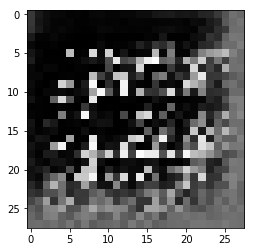

Iter  7000  |  D loss: 1.3865  G loss: -0.6934  D acc: 0.5234  G succ: 0.5469


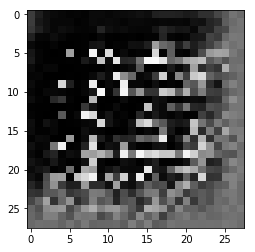

Iter  7500  |  D loss: 1.3860  G loss: -0.6932  D acc: 0.5234  G succ: 0.5312


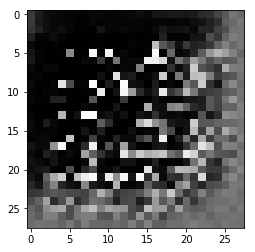

Iter  8000  |  D loss: 1.3861  G loss: -0.6929  D acc: 0.5312  G succ: 0.4062


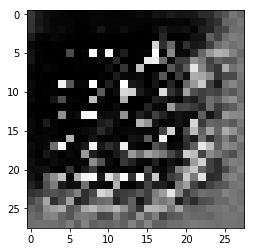

Iter  8500  |  D loss: 1.3866  G loss: -0.6931  D acc: 0.5078  G succ: 0.5156


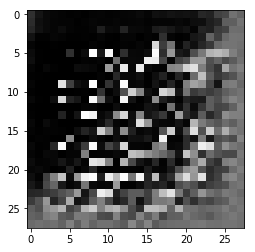

Iter  9000  |  D loss: 1.3860  G loss: -0.6934  D acc: 0.5078  G succ: 0.5000


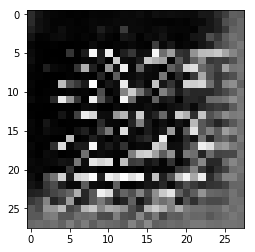

Iter  9500  |  D loss: 1.3864  G loss: -0.6929  D acc: 0.5391  G succ: 0.4219


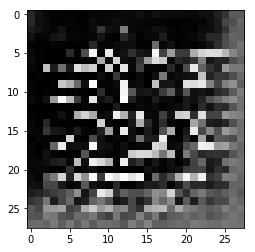

Iter 10000  |  D loss: 1.3871  G loss: -0.6931  D acc: 0.4219  G succ: 0.3750


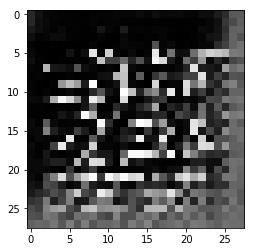

Iter 10500  |  D loss: 1.3863  G loss: -0.6929  D acc: 0.5000  G succ: 0.3906


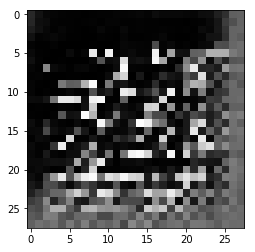

Iter 11000  |  D loss: 1.3858  G loss: -0.6929  D acc: 0.5625  G succ: 0.4531


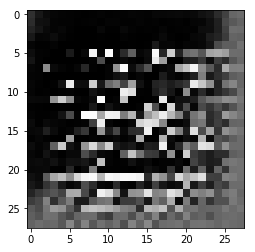

Iter 11500  |  D loss: 1.3862  G loss: -0.6930  D acc: 0.4766  G succ: 0.4375


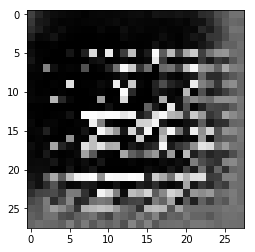

Iter 12000  |  D loss: 1.3864  G loss: -0.6930  D acc: 0.4688  G succ: 0.4062


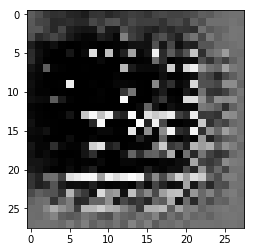

Iter 12500  |  D loss: 1.3860  G loss: -0.6929  D acc: 0.5234  G succ: 0.4844


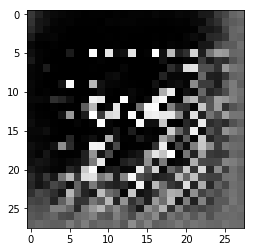

Iter 13000  |  D loss: 1.3860  G loss: -0.6931  D acc: 0.5234  G succ: 0.4844


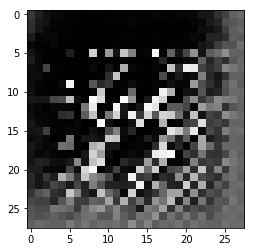

Iter 13500  |  D loss: 1.3862  G loss: -0.6929  D acc: 0.4844  G succ: 0.4844


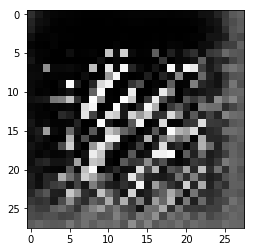

Iter 14000  |  D loss: 1.3869  G loss: -0.6935  D acc: 0.4375  G succ: 0.5000


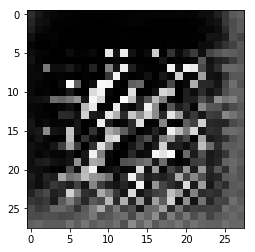

Iter 14500  |  D loss: 1.3861  G loss: -0.6931  D acc: 0.4922  G succ: 0.5000


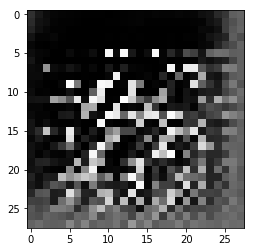

Iter 15000  |  D loss: 1.3869  G loss: -0.6933  D acc: 0.4531  G succ: 0.5156


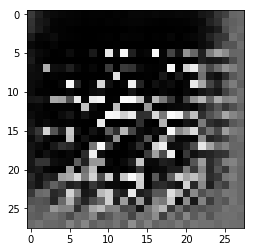

Iter 15500  |  D loss: 1.3867  G loss: -0.6933  D acc: 0.4688  G succ: 0.5625


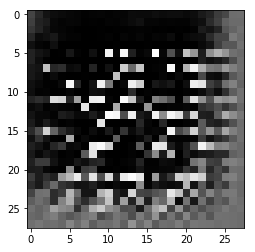

Iter 16000  |  D loss: 1.3862  G loss: -0.6931  D acc: 0.4531  G succ: 0.4844


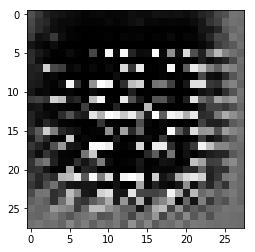

KeyboardInterrupt: ignored

In [261]:
mnist_loader_iterator = iter(mnist_loader)
discriminator = DiscriminatorMLP()
discriminator.to(device)
optim_d = optim.SGD(discriminator.parameters(), 
                    lr=lr_d, momentum=moment_d)


generator = GeneratorMLP(noise_dim)
generator.to(device)
optim_g = optim.SGD(generator.parameters(), 
                    lr=lr_g, momentum=moment_g)


d_losses = []
g_losses = []
d_acc = []
g_succ = []

for i in range(1, n_iters + 1):
    
    # Train discriminator k times
    for j in range(k):
        optim_d.zero_grad() 
        
        # Sample noise and data minibatches
        noise_batch, noise_labels = sample_noise_minibatch(noise_dim, batch_size)
        noise_batch, noise_labels = noise_batch.to(device), noise_labels.to(device)
        try:
            data_batch, data_labels = next(mnist_loader_iterator)
        except StopIteration:
            mnist_loader_iterator = iter(mnist_loader)
            data_batch, data_labels = next(mnist_loader_iterator)
        data_batch, data_labels = data_batch.to(device), data_labels.to(device)
            
        # Compute value function
        outputs_d = discriminator(data_batch)
        outputs_g = generator(noise_batch)
        outputs_dofg = discriminator(outputs_g)
        d_criterion = discriminator_criterion_neg(outputs_d, outputs_dofg)
        
        # Perform SGD on discriminator params with negative value function
        d_criterion.backward()
        optim_d.step()
        
        # Compute and store classification loss
        classification_loss = torch.nn.BCELoss()
        d_loss = classification_loss(outputs_d, data_labels)
        d_loss += classification_loss(outputs_dofg, noise_labels)
        d_losses.append(d_loss.item())
        
        # Compute and store discriminator classification accuracy
        n_correct = torch.sum((outputs_d > 0.5) == data_labels.byte())
        n_correct += torch.sum((outputs_dofg > 0.5) == noise_labels.byte())
        d_acc.append(n_correct.item() / (2 * batch_size))
    
    # Train generator
    optim_g.zero_grad()
    
    # Sample noise minibatch
    noise_batch, noise_labels = sample_noise_minibatch(noise_dim, batch_size)
    noise_batch, noise_labels = noise_batch.to(device), noise_labels.to(device)
    outputs_g = generator(noise_batch)
    outputs_dofg = discriminator(outputs_g)
    if i < n_iters_altloss:
        g_criterion = generator_criterion_early(outputs_dofg)
    else:
        g_criterion = generator_criterion(outputs_dofg)
    
    # Save loss for generator
    g_losses.append(generator_criterion(outputs_dofg).item())
    
    # Perform SGD on generator params with value function
    g_criterion.backward()
    optim_g.step()
    
    # Compute and store generator classification success
    n_correct = torch.sum((outputs_dofg > 0.5) != noise_labels.byte())
    g_succ.append(n_correct.item() / batch_size)
    
    if i % print_every == 0:
        # Print losses
        print("Iter %5d  |  D loss: %.4f  G loss: %.4f  D acc: %.4f  G succ: %.4f" %
              (i, d_losses[-1], g_losses[-1], d_acc[-1], g_succ[-1]))
        # Print an image from the outputs
        sample_output = outputs_g[0, :].view((28, 28)).detach().cpu().numpy()
        imshow(sample_output, cmap='gray', vmin=0, vmax=1)
        plt.show()
    

Text(0, 0.5, 'log(1 - D(G(z)))')

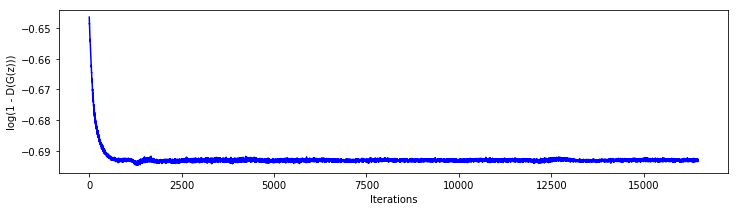

In [262]:
fig = plt.figure(figsize=(12,3))
plt.plot(g_losses, color='blue')
plt.xlabel('Iterations')
plt.ylabel('log(1 - D(G(z)))')

Text(0, 0.5, 'BCE for D')

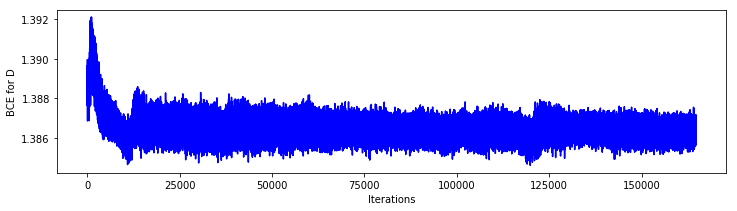

In [263]:
fig = plt.figure(figsize=(12,3))
plt.plot(d_losses, color='blue')
plt.xlabel('Iterations')
plt.ylabel('BCE for D')

Text(0, 0.5, 'Generator Success')

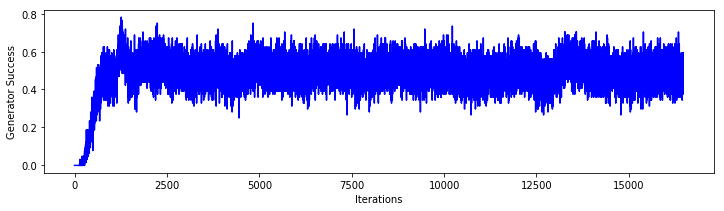

In [264]:
fig = plt.figure(figsize=(12,3))
plt.plot(g_succ, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Generator Success')

Text(0, 0.5, 'Discriminator Acuracy')

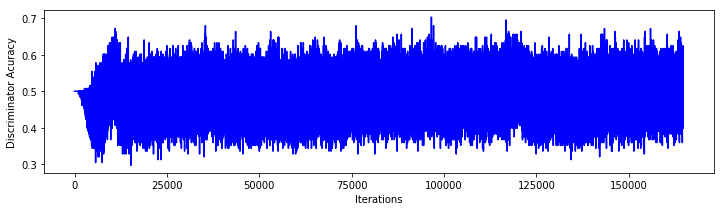

In [265]:
fig = plt.figure(figsize=(12,3))
plt.plot(d_acc, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Discriminator Acuracy')